# Cross validate spatially
In this script, cross validation is performed spatially.  
To do this, the sensors are split into clusters (of roughly even numbers of hourly values).    
The model is then fit on all but one of the clusters, and tested on the remaining cluster.  
This is done iteratively until each cluster has been used as testing once.  

Potential issues: different sensors cover different periods of time

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.colors as colors
from sklearn.model_selection import TimeSeriesSplit
import time as time
#  Spatial packages
from shapely.geometry import Point
import geopandas as gpd
import contextily as cx
# Machine learning packages
# import xgboost as xgb

# Custom function for neg_mean_absolute_percentage_error
def neg_mean_absolute_percentage_error(y_true, y_pred):
    return -100 * np.mean(np.abs((y_true - y_pred) / y_true))

from Functions import *

### Get the necessary data
#### Get testing and training data
Specify buffer size (as there are different versions of the data created with different buffer sizes)

In [10]:
buffer_size_m = 500
input_csv ="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)

#### Drop one version of the time variables (either cyclical or dummy versions)

In [11]:
# If using the dummy variables
# Xfull.drop(['Cos_month_num', 'Sin_month_num', 'Cos_weekday_num', 'Sin_weekday_num'], axis=1)
# If using the cyclical variables
Xfull.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], axis=1, inplace = True)

#### Delete the year variable

In [12]:
del Xfull['year']

#### Get the sensor locations (this is needed if splitting the data spatially in cross validation)

In [13]:
melbourne_sensors = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")

#### Get as series the sensor ids and datetimes

In [14]:
sensor_ids = pd.read_csv(input_csv)['sensor_id']
datetimes = pd.read_csv(input_csv)['datetime']

### Define the error metrics for the cross-validation to return, and the parameters of the cross validation

In [15]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']

### Set up model pipelines

In [16]:
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 10)]])

In [17]:
models_dict = {"rf_regressor":rf_model_pipeline}

## Cross validation manually 

### Make spatial clusters
Use Kmeans and then do some manual shuffling to make the clusters more evenly sized

In [129]:
n_spatial_clusters = 10 # NB this number of spatial splits ends up being smaller

In [315]:
Xfull['sensor_id'] = sensor_ids
# Get list of sensors which have data in this time block
list_sensors = Xfull['sensor_id'].unique().tolist()

##############################################################
# Run K-means clustering using just these sensors (i.e. with data in this timeslice)
# Based on coordinates of sensors
##############################################################            
# Get dataframe containing coordinates for these sensors
coordinates_to_cluster = melbourne_sensors[['Latitude','Longitude']].copy()   

# Initialize KMeans instance
kmeans = KMeans(n_clusters=n_spatial_clusters, random_state=0).fit(coordinates_to_cluster)
# coordinates_to_cluster['Kmeans_clusternum'] = kmeans.labels_

##############################################################
# Join back on to main dataset (X) 
# So now X includes a column containing the cluster number of each row
# If the row is from a sensor not present in this timeslice, it will have NA
# Rows not within this timeslice, but with a sensor ID present in this timeslice
# will get the cluster number for that sensor in this timeslice, but this will be overridden
# in the future when that timeslice is considered
##############################################################      
# Remove a cluster number column if it was already created in previous iteration
if 'Cluster_number' in Xfull.columns:
    Xfull = Xfull.drop('Cluster_number', axis=1)

# Join the cluster number back onto the dataset of sensors present in this timeslice
melbourne_sensors['Cluster_number'] = kmeans.labels_

# Join this onto X (so now all rows with that sensor_id will show as being in that cluster)
# Including rows not within this timeslice, but this shouldn't matter
Xfull = pd.merge(Xfull, melbourne_sensors[['sensor_id','Cluster_number']], on='sensor_id', how='left')

### Join the two clusters on edge

In [316]:
melbourne_sensors.loc[melbourne_sensors.Cluster_number ==4 , 'Cluster_number'] = 3  
Xfull.loc[Xfull.Cluster_number ==4 , 'Cluster_number'] = 3  

melbourne_sensors.loc[melbourne_sensors.Cluster_number ==5 , 'Cluster_number'] = 3  
Xfull.loc[Xfull.Cluster_number ==5 , 'Cluster_number'] = 3  

### Join southern clusters

In [317]:
melbourne_sensors.loc[melbourne_sensors.Cluster_number ==1 , 'Cluster_number'] = 7  
Xfull.loc[Xfull.Cluster_number ==1 , 'Cluster_number'] = 7  

### Add south of river blue to the south of river cluster

In [318]:
melbourne_sensors.loc[melbourne_sensors.sensor_id ==14 , 'Cluster_number'] =9 
melbourne_sensors.loc[melbourne_sensors.sensor_id ==28 , 'Cluster_number'] =9  
melbourne_sensors.loc[melbourne_sensors.sensor_id ==29 , 'Cluster_number'] =9 
melbourne_sensors.loc[melbourne_sensors.sensor_id ==35 , 'Cluster_number'] =9  
Xfull.loc[Xfull.sensor_id ==14 , 'Cluster_number'] =9  
Xfull.loc[Xfull.sensor_id ==28, 'Cluster_number'] =9 
Xfull.loc[Xfull.sensor_id ==29 , 'Cluster_number'] =9  
Xfull.loc[Xfull.sensor_id ==35 , 'Cluster_number'] =9  

In [319]:
melbourne_sensors.loc[melbourne_sensors.sensor_id ==8 , 'Cluster_number'] =9  
Xfull.loc[Xfull.sensor_id ==8 , 'Cluster_number'] =9  

### Check plotting

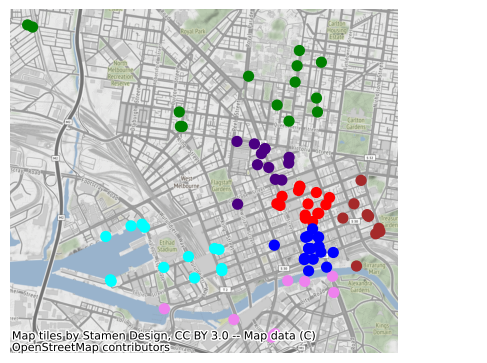

In [325]:
fig, ax = plt.subplots(figsize=(5,5))
geometry = [Point(xy) for xy in zip(melbourne_sensors.Longitude,
                                    melbourne_sensors.Latitude)]
gdf = gpd.GeoDataFrame(melbourne_sensors, geometry=geometry)
gdf = gdf.set_crs('EPSG:4326')
gdf = gdf.to_crs('epsg:3857')
colors_ls = ['black'] * n_spatial_clusters
color = ['red', 'purple', 'blue', 'green', 'yellow', 'orange','brown','cyan', 'indigo', 'violet']

# If there's just one temporal split, just make one plot
my_plot = gdf.plot(column=gdf.Cluster_number, ax = ax, markersize = 50, cmap=colors.ListedColormap(color))
cx.add_basemap(ax = ax)
ax.axis('off')
ax.set_axis_off()

### Check differences in number of sensors in each cluster

In [321]:
for cluster_num in np.sort(Xfull['Cluster_number'].unique()):
    print(cluster_num, len(Xfull[Xfull['Cluster_number']==cluster_num]))

0 845764
2 629544
3 535381
6 558890
7 647493
8 444203
9 467807


## Run the cross validation
Loop through each cluster, and set that cluster as testing and the rest as training

In [110]:
# Lists to store the scores
mae_scores = []
rmse_scores= []
r2_scores= []
neg_mae_scores = []
# Lists to store predicetd and actual values
predicted_values=[]
observed_values = []
# List to store the datetimes
datetimes_used = []

In [386]:
start = time()
# Loop through each of the cross validation splits
for cluster_num in Xfull['Cluster_number'].unique():
    
    train_index = Xfull.index[Xfull['Cluster_number'] != cluster_num].tolist()
    test_index = Xfull.index[Xfull['Cluster_number'] == cluster_num].tolist()
    
    # Get train and testing data for this fold
    print(f"train index: {len(train_index)}")
    print(f"test index: {len(test_index)}")
    print(f"percentage of data used as testing: {round(len(test_index)/len(train_index)*100,1)}")
    X_train, X_test = Xfull.iloc[train_index], Xfull.iloc[test_index]
    y_train, y_test = Yfull[train_index], Yfull[test_index]
    # Fit the model on the training data
    rf_model_pipeline.fit(X_train, y_train)
    # Use it to make predictions on the testing data, and store these
    y_pred = rf_model_pipeline.predict(X_test)
    predicted_values.append(y_pred)
    # Store the datetimes
    datetimes_used.append(datetimes[train_index])
    # Store the actual values for the testing data
    observed_values.append(Yfull[y_test])
    # Calculate the error metrics for this fold and append to the scores lists
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(mean_squared_error(y_test, y_pred, squared=False))
neg_mae_scores = [-score for score in mae_scores]       

end = time()
print('Ran cross_val_predict in {} minutes'.format(round((end - start)/60),2))

train index: 3661275
test index: 467807
percentage of data used as testing: 12.8
train index: 3283318
test index: 845764
percentage of data used as testing: 25.8
train index: 3570192
test index: 558890
percentage of data used as testing: 15.7
train index: 3481589
test index: 647493
percentage of data used as testing: 18.6
train index: 3684879
test index: 444203
percentage of data used as testing: 12.1
train index: 3499538
test index: 629544
percentage of data used as testing: 18.0
train index: 3593701
test index: 535381
percentage of data used as testing: 14.9


In [352]:
# # len(Xfull['Cluster_number'].unique())
# datetimes_used = datetimes_used[6:]
# mae_scores = mae_scores[6:]
# r2_scores = r2_scores[6:]
# rmse_scores = rmse_scores[6:]
# neg_mae_scores = neg_mae_scores[6:]
# observed_values = observed_values[6:]

## Scores (across all cross validation runs)

In [383]:
mean_mae = np.mean(mae_scores)
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)

print(f"Mean absoloute error: {mean_mae}")
print(f"Mean R2: {mean_r2}")
print(f"Mean RMSE: {mean_rmse}")

Mean absoloute error: 380.20785678124304
Mean R2: -2.3368351810261054
Mean RMSE: 544.1229005066604


## Plot Predicted vs Observed (averaged across all CV runs)

In [ ]:
predicted_values_all = []
observed_values_all= []
for i in range(len(predicted_values)):
    for j in range(len(predicted_values[i])):
        observed_values_all.append(observed_values[i][j])
        predicted_values_all.append(predicted_values[i][j])

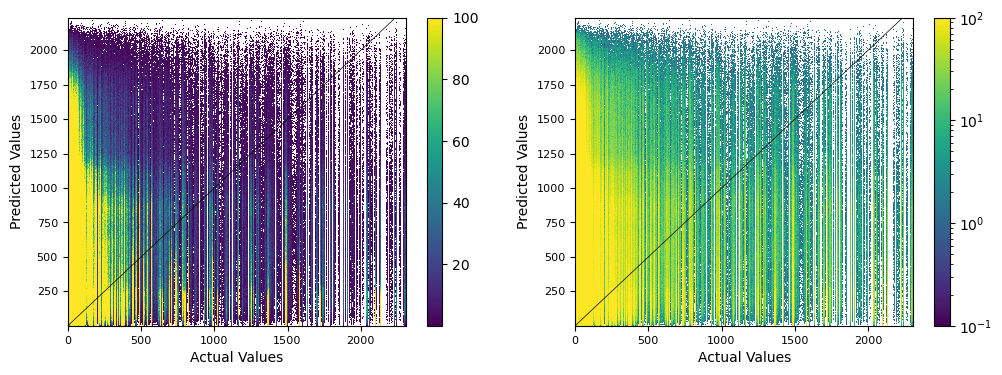

In [384]:
import datashader as ds
from datashader.mpl_ext import dsshow
fig, axs = plt.subplots(ncols=2, figsize = (12,4))

# Plot with linear scale
using_datashader(axs[0], observed_values_all, predicted_values_all, 'linear')
axs[0].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[0].set_ylabel("Predicted Values", size=10)
axs[0].set_xlabel("Actual Values", size=10)
#axs[0].set_xlim([0, 2000])
#axs[0].set_ylim([0, 2000])
axs[0].tick_params(axis='both', which='major', labelsize=8)

# Plot with log scale
using_datashader(axs[1], observed_values_all, predicted_values_all, 'log')
axs[1].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
# axs[1].set_xlim([0, 2000])
# axs[1].set_ylim([0, 2000]);
axs[1].tick_params(axis='both', which='major', labelsize=8)

## Plot predicted vs observed (for each spatial split iteration separately)

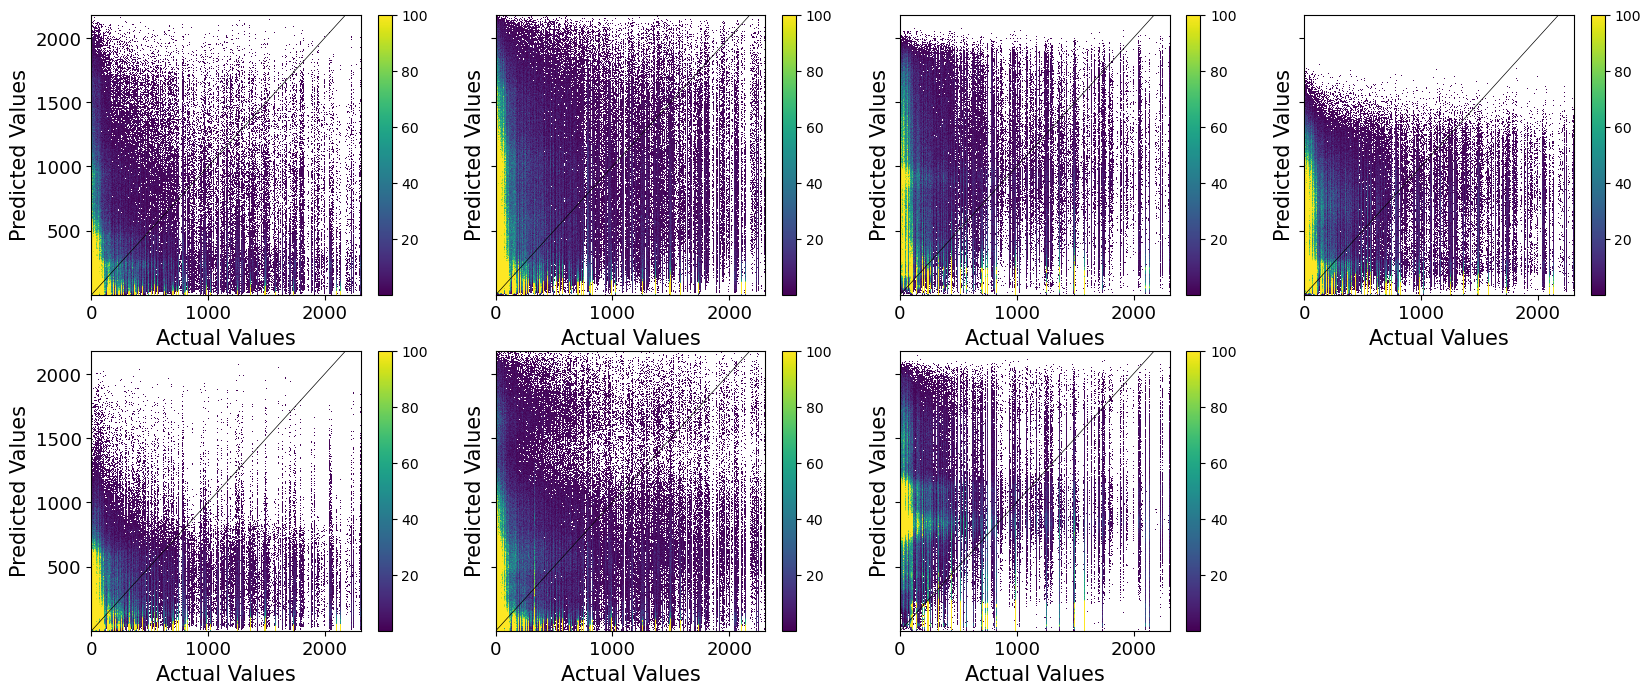

In [387]:
fig, axs = plt.subplots(ncols=4,nrows=2, figsize = (20,8), sharey=True)

for i, ax in enumerate(axs.flat):
    if i != 7:
        using_datashader(ax, observed_values[i], predicted_values[i], 'linear')
        ax.plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
        ax.set_ylabel("Predicted Values", size=15)
        ax.set_xlabel("Actual Values", size=15)
        ax.tick_params(axis='both', which='major', labelsize=13)
    if i ==7:
        ax.axis('off')